In [1]:
"""
ClimateWins Random Forest Analysis
Task: Determine the most useful weather features for predicting pleasant days

Author: Data Science Bootcamp
Estimated Time: 4-6 hours
"""

# ============================================================================
# IMPORTS AND SETUP
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from sklearn.tree import plot_tree
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('fivethirtyeight')
sns.set_palette("husl")

In [4]:
# ============================================================================
# STEP 1: LOAD THE DATA
# ============================================================================
print("="*80)
print("STEP 1: LOADING DATA")
print("="*80)

# Define file paths
data_path = '/Users/davidscheider/anaconda_projects/ClimateWins/02 Data/Original Data/'
weather_file = 'Dataset-weather-prediction-dataset-CLEANED.csv'
pleasant_file = 'Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv'

# Load the cleaned weather data
df_weather = pd.read_csv(data_path + weather_file)
print(f"\nWeather data loaded: {df_weather.shape}")
print(f"Columns: {list(df_weather.columns)}")

# Load the pleasant weather labels
df_pleasant = pd.read_csv(data_path + pleasant_file)
print(f"\nPleasant weather data loaded: {df_pleasant.shape}")
print(f"Columns: {list(df_pleasant.columns)}")

# Display first few rows
print("\nFirst 5 rows of weather data:")
print(df_weather.head())
print("\nFirst 5 rows of pleasant weather data:")
print(df_pleasant.head())

# Check data info
print("\nWeather data info:")
print(df_weather.info())


STEP 1: LOADING DATA

Weather data loaded: (22950, 137)
Columns: ['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_humidity', 'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation', 'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min', 'BASEL_temp_max', 'BELGRADE_cloud_cover', 'BELGRADE_humidity', 'BELGRADE_pressure', 'BELGRADE_global_radiation', 'BELGRADE_precipitation', 'BELGRADE_sunshine', 'BELGRADE_temp_mean', 'BELGRADE_temp_min', 'BELGRADE_temp_max', 'BUDAPEST_cloud_cover', 'BUDAPEST_humidity', 'BUDAPEST_pressure', 'BUDAPEST_global_radiation', 'BUDAPEST_precipitation', 'BUDAPEST_sunshine', 'BUDAPEST_temp_mean', 'BUDAPEST_temp_min', 'BUDAPEST_temp_max', 'DEBILT_cloud_cover', 'DEBILT_humidity', 'DEBILT_pressure', 'DEBILT_global_radiation', 'DEBILT_precipitation', 'DEBILT_sunshine', 'DEBILT_temp_mean', 'DEBILT_temp_min', 'DEBILT_temp_max', 'DUSSELDORF_cloud_cover', 'DUSSELDORF_humidity', 'DUSSELDORF_pressure', 'DUSSELDORF_global_radiation', 'DUSSELDORF_precipitation', 'DUSSEL

In [5]:
# ============================================================================
# STEP 2: PREPARE DATA - ONE DECADE AT A TIME
# ============================================================================
print("\n" + "="*80)
print("STEP 2: PREPARING DATA FOR RANDOM FOREST MODEL")
print("="*80)

# First, let's examine what columns we actually have
print("\nWeather data columns:")
print(df_weather.columns.tolist())
print("\nPleasant weather columns:")
print(df_pleasant.columns.tolist())

# Merge weather data with pleasant weather labels on DATE
df_merged = pd.merge(df_weather, df_pleasant, on='DATE', how='inner')

print(f"\nMerged data shape: {df_merged.shape}")
print(f"Number of weather stations: {len([col for col in df_pleasant.columns if 'pleasant' in col])}")

# Get list of all pleasant weather columns (one per station)
pleasant_cols = [col for col in df_merged.columns if 'pleasant_weather' in col]
print(f"\nPleasant weather columns ({len(pleasant_cols)}):")
for col in pleasant_cols:
    print(f"  - {col}")

# Create a combined target: a day is "pleasant" if it's pleasant at ANY station
# This gives us a single target variable
df_merged['pleasant_weather_any'] = df_merged[pleasant_cols].max(axis=1)

# Alternative: a day is pleasant if it's pleasant at MOST stations (majority vote)
df_merged['pleasant_weather_majority'] = (df_merged[pleasant_cols].mean(axis=1) >= 0.5).astype(int)

# Count pleasant days
print(f"\nPleasant days (if pleasant at ANY station): {df_merged['pleasant_weather_any'].sum()} out of {len(df_merged)} ({df_merged['pleasant_weather_any'].mean()*100:.1f}%)")
print(f"Pleasant days (if pleasant at MAJORITY of stations): {df_merged['pleasant_weather_majority'].sum()} out of {len(df_merged)} ({df_merged['pleasant_weather_majority'].mean()*100:.1f}%)")

# For this analysis, we'll use the "majority" approach as it's more balanced
target_col_name = 'pleasant_weather_majority'
print(f"\nUsing target: {target_col_name}")

# Extract date information if available
date_col = 'DATE'
df_merged[date_col] = pd.to_datetime(df_merged[date_col], format='%Y%m%d')
df_merged['year'] = df_merged[date_col].dt.year

# Filter for one decade (use 2000-2009 as example, or adjust to your data)
all_years = sorted(df_merged['year'].unique())
print(f"\nAvailable years in dataset: {all_years[0]} to {all_years[-1]}")

# Use the first decade
decade_start = all_years[0]
decade_end = min(decade_start + 9, all_years[-1])

print(f"\nFiltering data for decade: {decade_start}-{decade_end}")
df_decade = df_merged[
    (df_merged['year'] >= decade_start) & 
    (df_merged['year'] <= decade_end)
].copy()

print(f"Decade data shape: {df_decade.shape}")

# Separate features (X) and target (y)
# Exclude all pleasant_weather columns, date columns, padding, etc.
exclude_cols = [target_col_name, 'DATE', 'date', 'year', 'MONTH', 'PADDING_0', 'PADDING_1']
exclude_cols.extend(pleasant_cols)  # Exclude all individual station pleasant weather columns

feature_cols = [col for col in df_decade.columns 
                if col not in exclude_cols and df_decade[col].dtype in ['int64', 'float64']]

X = df_decade[feature_cols].copy()
y = df_decade[target_col_name].copy()

# Handle any missing values
print(f"\nMissing values in X: {X.isnull().sum().sum()}")
print(f"Missing values in y: {y.isnull().sum()}")

X = X.fillna(X.mean())
y = y.fillna(y.mode()[0])

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeature columns ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nTraining set: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing set: X_test {X_test.shape}, y_test {y_test.shape}")


STEP 2: PREPARING DATA FOR RANDOM FOREST MODEL

Weather data columns:
['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_humidity', 'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation', 'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min', 'BASEL_temp_max', 'BELGRADE_cloud_cover', 'BELGRADE_humidity', 'BELGRADE_pressure', 'BELGRADE_global_radiation', 'BELGRADE_precipitation', 'BELGRADE_sunshine', 'BELGRADE_temp_mean', 'BELGRADE_temp_min', 'BELGRADE_temp_max', 'BUDAPEST_cloud_cover', 'BUDAPEST_humidity', 'BUDAPEST_pressure', 'BUDAPEST_global_radiation', 'BUDAPEST_precipitation', 'BUDAPEST_sunshine', 'BUDAPEST_temp_mean', 'BUDAPEST_temp_min', 'BUDAPEST_temp_max', 'DEBILT_cloud_cover', 'DEBILT_humidity', 'DEBILT_pressure', 'DEBILT_global_radiation', 'DEBILT_precipitation', 'DEBILT_sunshine', 'DEBILT_temp_mean', 'DEBILT_temp_min', 'DEBILT_temp_max', 'DUSSELDORF_cloud_cover', 'DUSSELDORF_humidity', 'DUSSELDORF_pressure', 'DUSSELDORF_global_radiation', 'DUSSELDORF_precipitation', '


STEP 3: CREATING AND RUNNING RANDOM FOREST MODEL

Creating Random Forest with:
  - n_estimators: 100
  - max_depth: 10

Training the model...
Training complete!

Plotting decision trees...


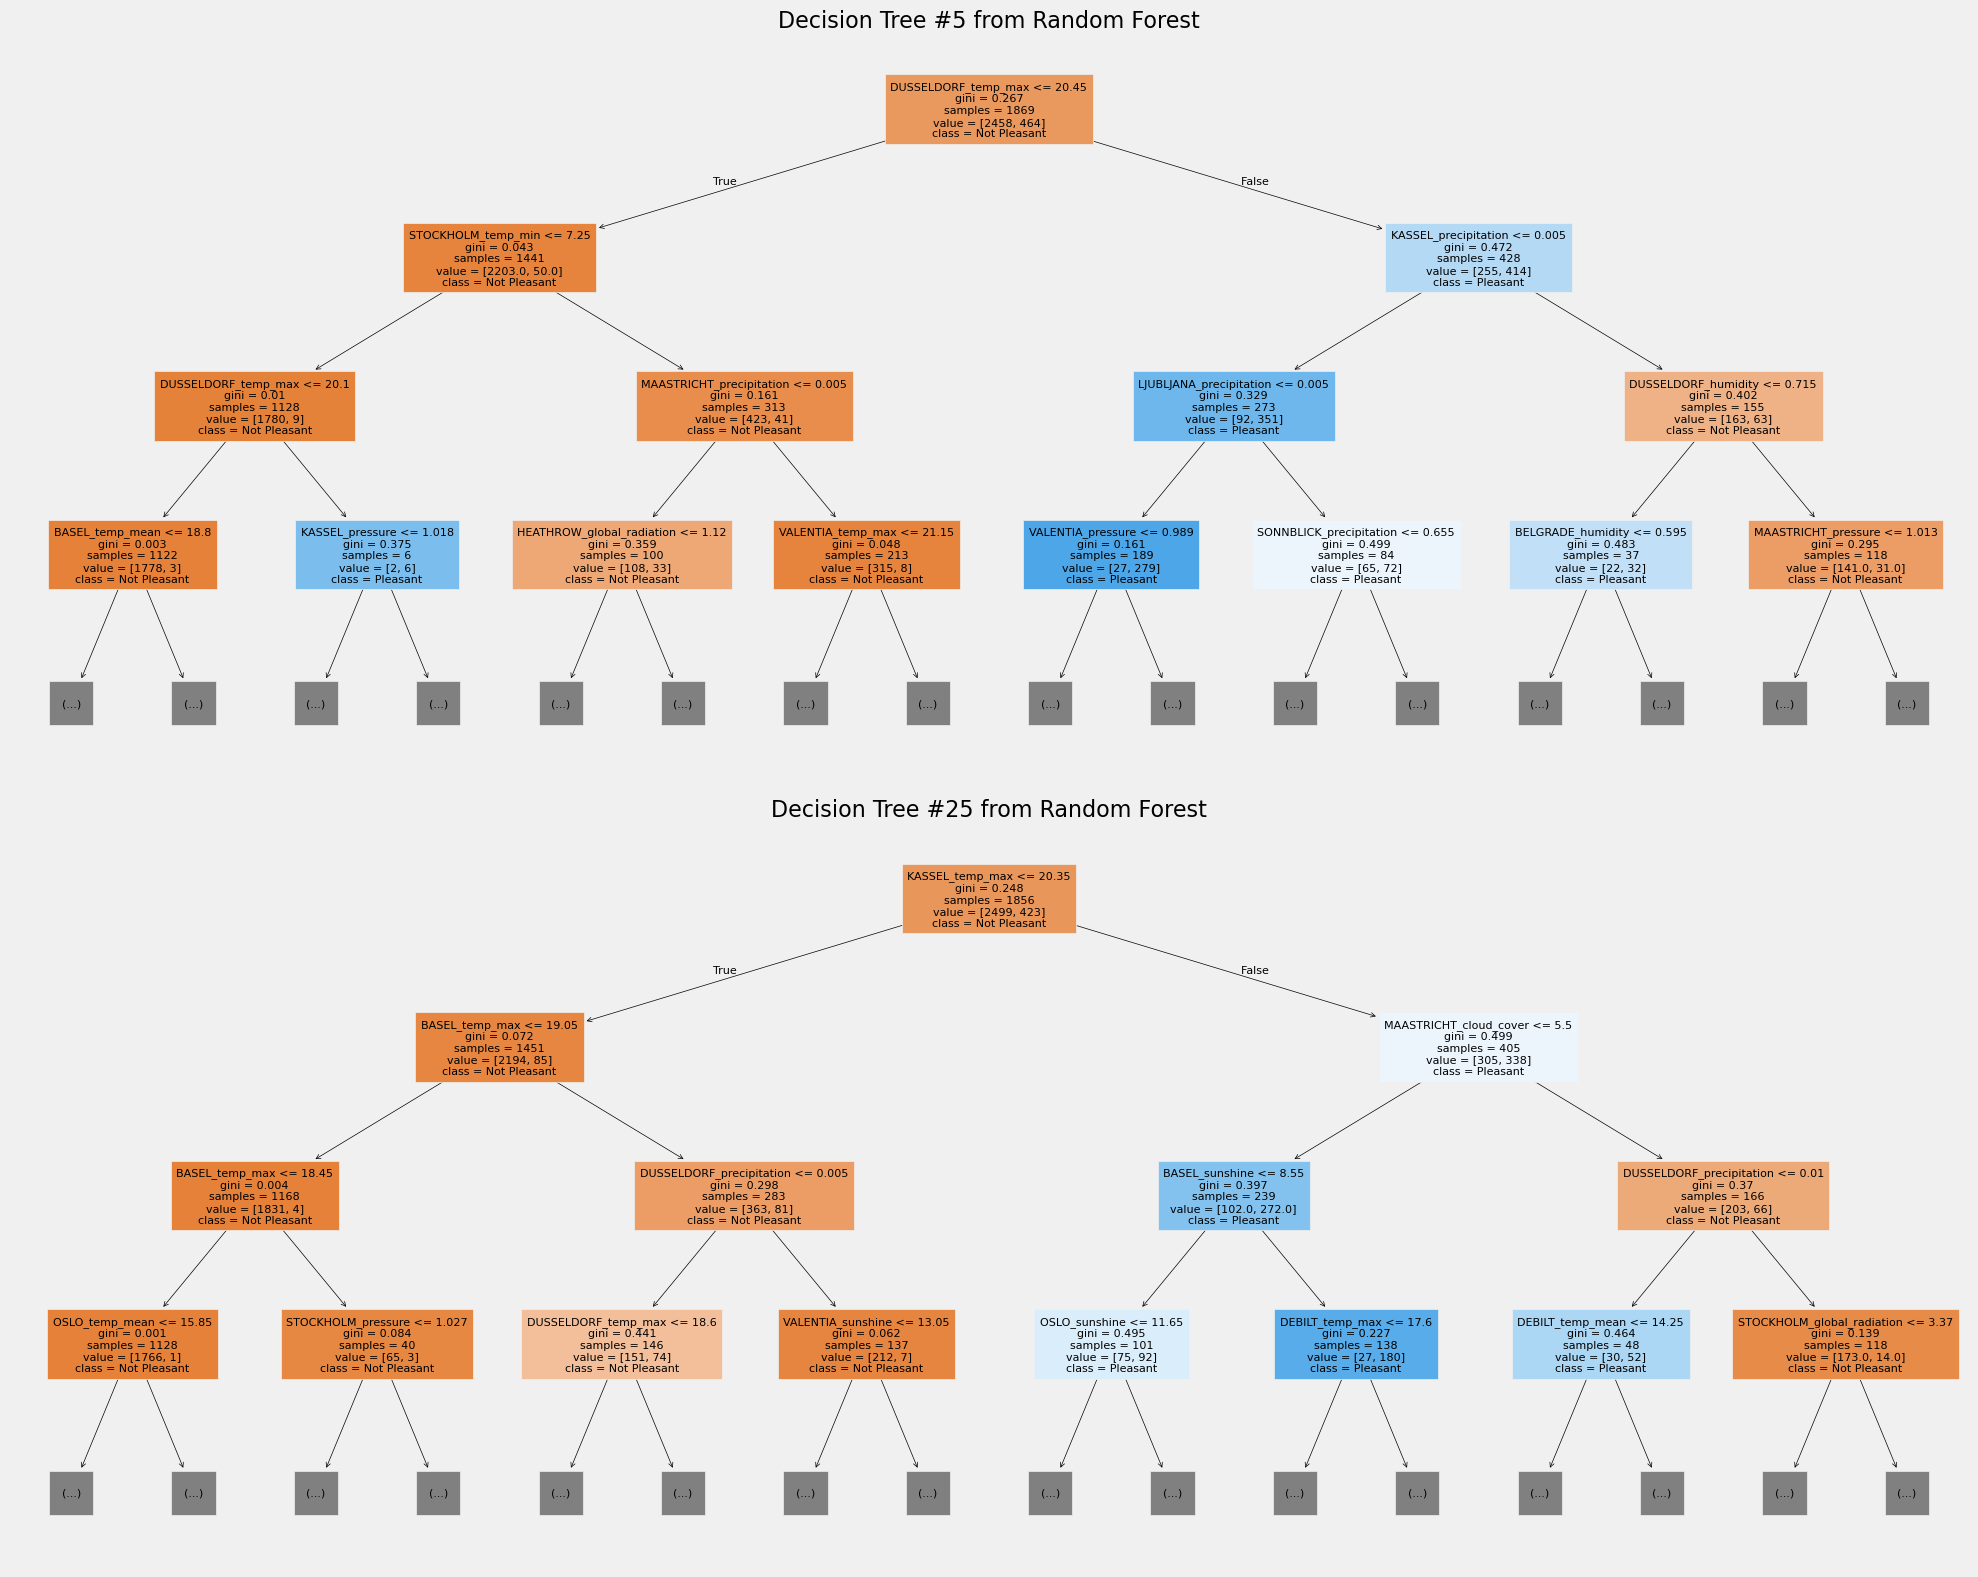

Decision tree plots saved as 'random_forest_trees_comparison.png'


In [7]:
### ============================================================================
# STEP 3: CREATE AND RUN RANDOM FOREST MODEL
# ============================================================================
print("\n" + "="*80)
print("STEP 3: CREATING AND RUNNING RANDOM FOREST MODEL")
print("="*80)

# Create random forest classifier
n_estimators = 100
max_depth = 10

print(f"\nCreating Random Forest with:")
print(f"  - n_estimators: {n_estimators}")
print(f"  - max_depth: {max_depth}")

clf = RandomForestClassifier(
    n_estimators=n_estimators, 
    max_depth=max_depth,
    random_state=42
)

# Fit the model
print("\nTraining the model...")
clf.fit(X_train, y_train)
print("Training complete!")

# Plot two different trees
print("\nPlotting decision trees...")

fig, axes = plt.subplots(2, 1, figsize=(20, 16))

# Tree #5
tree_idx_1 = 5
plot_tree(
    clf.estimators_[tree_idx_1], 
    ax=axes[0],
    feature_names=feature_cols,
    class_names=['Not Pleasant', 'Pleasant'],
    filled=True,
    fontsize=8,
    max_depth=3  # Limit depth for visibility
)
axes[0].set_title(f'Decision Tree #{tree_idx_1} from Random Forest', fontsize=16)

# Tree #25
tree_idx_2 = 25
plot_tree(
    clf.estimators_[tree_idx_2], 
    ax=axes[1],
    feature_names=feature_cols,
    class_names=['Not Pleasant', 'Pleasant'],
    filled=True,
    fontsize=8,
    max_depth=3  # Limit depth for visibility
)
axes[1].set_title(f'Decision Tree #{tree_idx_2} from Random Forest', fontsize=16)

plt.tight_layout()
plt.savefig('random_forest_trees_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Decision tree plots saved as 'random_forest_trees_comparison.png'")



STEP 4: MODEL ACCURACY

Model Accuracy: 0.9494 (94.94%)

Classification Report:
              precision    recall  f1-score   support

Not Pleasant       0.96      0.98      0.97       622
    Pleasant       0.89      0.75      0.82       109

    accuracy                           0.95       731
   macro avg       0.92      0.87      0.89       731
weighted avg       0.95      0.95      0.95       731


Confusion Matrix:
[[612  10]
 [ 27  82]]


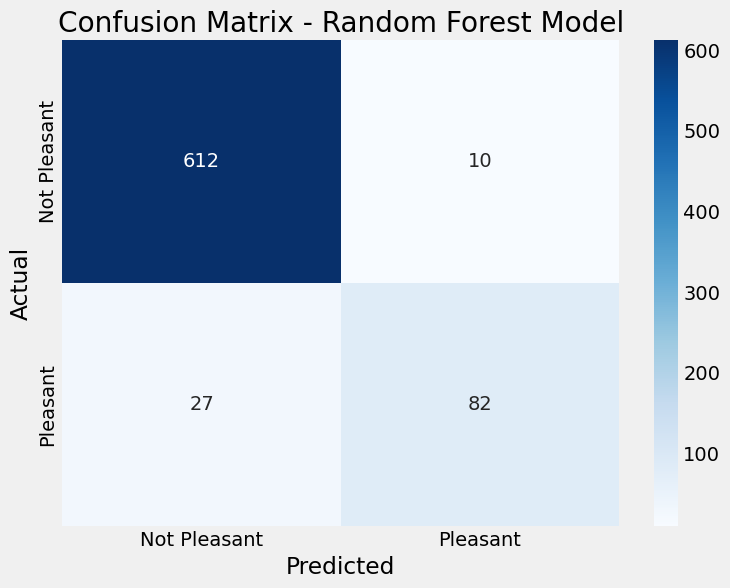

In [8]:
# ============================================================================
# STEP 4: RECORD MODEL ACCURACY
# ============================================================================
print("\n" + "="*80)
print("STEP 4: MODEL ACCURACY")
print("="*80)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Additional metrics
print("\nClassification Report:")
print(metrics.classification_report(y_test, y_pred, 
                                   target_names=['Not Pleasant', 'Pleasant']))

# Confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Pleasant', 'Pleasant'],
            yticklabels=['Not Pleasant', 'Pleasant'])
plt.title('Confusion Matrix - Random Forest Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()



STEP 5: FEATURE IMPORTANCES

Feature importances shape: (134,)
Number of features: 134

Top 20 Most Important Features:
                         Feature  Importance
79           MAASTRICHT_temp_max    0.069917
44           DUSSELDORF_temp_max    0.041680
8                 BASEL_temp_max    0.040121
61               KASSEL_temp_max    0.039201
77          MAASTRICHT_temp_mean    0.036846
35               DEBILT_temp_max    0.036438
57          KASSEL_precipitation    0.034427
40      DUSSELDORF_precipitation    0.032114
6                BASEL_temp_mean    0.030253
75      MAASTRICHT_precipitation    0.028782
42          DUSSELDORF_temp_mean    0.027190
53             HEATHROW_temp_max    0.026578
132           KASSEL_cloud_cover    0.022605
31          DEBILT_precipitation    0.021113
33              DEBILT_temp_mean    0.015223
96             MUNCHENB_temp_max    0.013451
59              KASSEL_temp_mean    0.013385
74   MAASTRICHT_global_radiation    0.013308
73           MAASTRICHT_

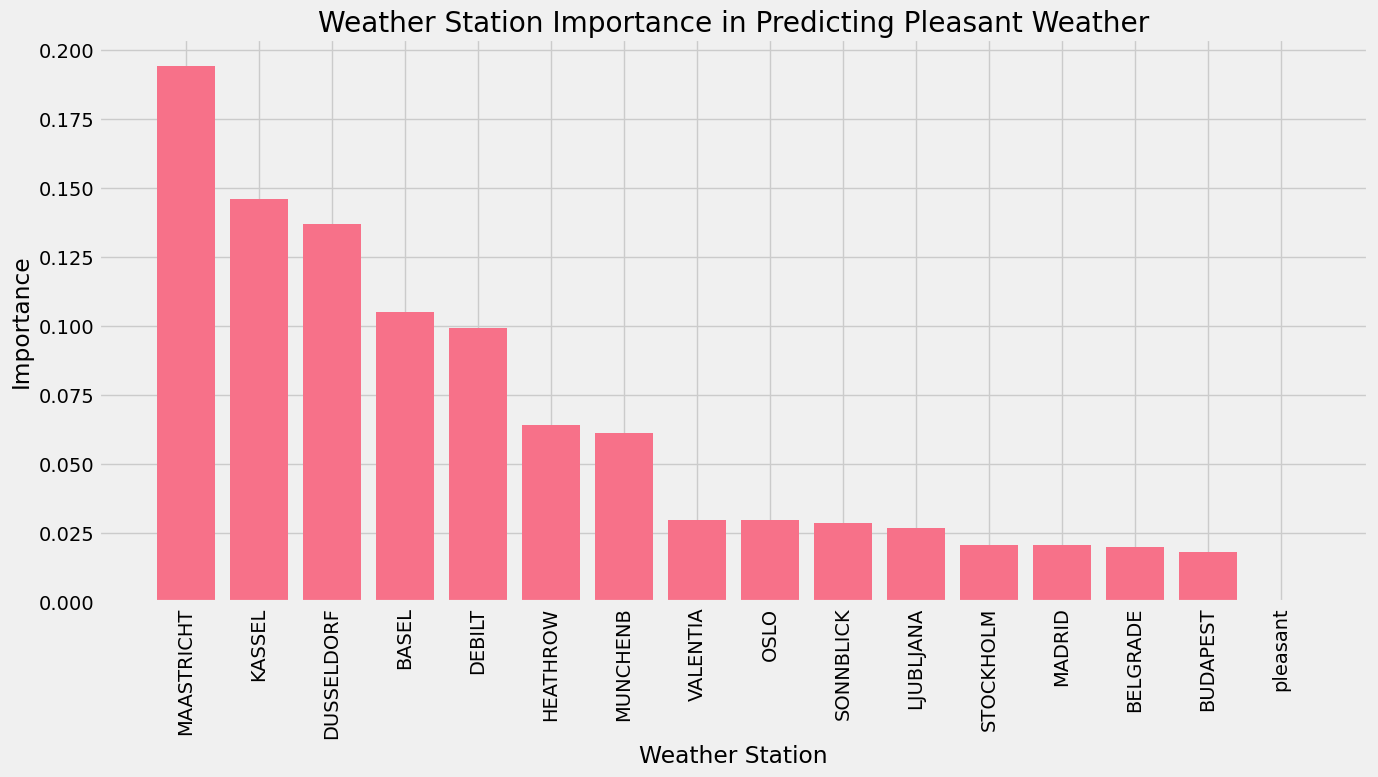


Top 3 Most Important Weather Stations:
  1. MAASTRICHT: 0.1940
  2. KASSEL: 0.1461
  3. DUSSELDORF: 0.1368


In [9]:
# ============================================================================
# STEP 5: FEATURE IMPORTANCES
# ============================================================================
print("\n" + "="*80)
print("STEP 5: FEATURE IMPORTANCES")
print("="*80)

# Get feature importances
importances = clf.feature_importances_

print(f"\nFeature importances shape: {importances.shape}")
print(f"Number of features: {len(feature_cols)}")

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(importance_df.head(20))

# Note: The reshaping step mentioned in the instructions assumes 
# the data is structured as (observations, weather_stations, measurements)
# This would be: reshape to (-1, 15, 9) meaning 15 weather stations with 9 observations each
# We'll attempt this if the structure matches

print("\n" + "="*80)
print("STEP 6: WEATHER STATION IMPORTANCE ANALYSIS")
print("="*80)

# Attempt to identify weather station structure in feature names
# Typical naming might be: StationName_ObservationType
station_importance = {}

for feat, imp in zip(feature_cols, importances):
    # Try to extract station name (assuming format: Station_Observation)
    if '_' in feat:
        station = feat.split('_')[0]
    else:
        station = feat
    
    if station not in station_importance:
        station_importance[station] = 0
    station_importance[station] += imp

# Create DataFrame of station importances
station_df = pd.DataFrame(
    list(station_importance.items()),
    columns=['Station', 'Total_Importance']
).sort_values('Total_Importance', ascending=False)

print("\nWeather Station Importances:")
print(station_df)

# Plot station importances
plt.figure(figsize=(14, 8))
plt.bar(range(len(station_df)), station_df['Total_Importance'])
plt.xticks(range(len(station_df)), station_df['Station'], rotation=90)
plt.xlabel('Weather Station')
plt.ylabel('Importance')
plt.title('Weather Station Importance in Predicting Pleasant Weather')
plt.tight_layout()
plt.savefig('station_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 3 Most Important Weather Stations:")
top_3_stations = station_df.head(3)['Station'].tolist()
for i, station in enumerate(top_3_stations, 1):
    imp = station_df[station_df['Station'] == station]['Total_Importance'].values[0]
    print(f"  {i}. {station}: {imp:.4f}")



STEPS 7 & 8: ANALYZING TOP 3 INDIVIDUAL STATIONS

ANALYZING STATION 1: MAASTRICHT

Features for MAASTRICHT: 9
  - MAASTRICHT_cloud_cover
  - MAASTRICHT_humidity
  - MAASTRICHT_pressure
  - MAASTRICHT_global_radiation
  - MAASTRICHT_precipitation
  - MAASTRICHT_sunshine
  - MAASTRICHT_temp_mean
  - MAASTRICHT_temp_min
  - MAASTRICHT_temp_max

Station data shape: X (22950, 9), y (22950,)
Target variable: MAASTRICHT_pleasant_weather
Pleasant days for MAASTRICHT: 4766 out of 22950 (20.8%)

Training Random Forest for MAASTRICHT...
Accuracy for MAASTRICHT: 1.0000 (100.00%)

Classification Report for MAASTRICHT:
              precision    recall  f1-score   support

Not Pleasant       1.00      1.00      1.00      3657
    Pleasant       1.00      1.00      1.00       933

    accuracy                           1.00      4590
   macro avg       1.00      1.00      1.00      4590
weighted avg       1.00      1.00      1.00      4590



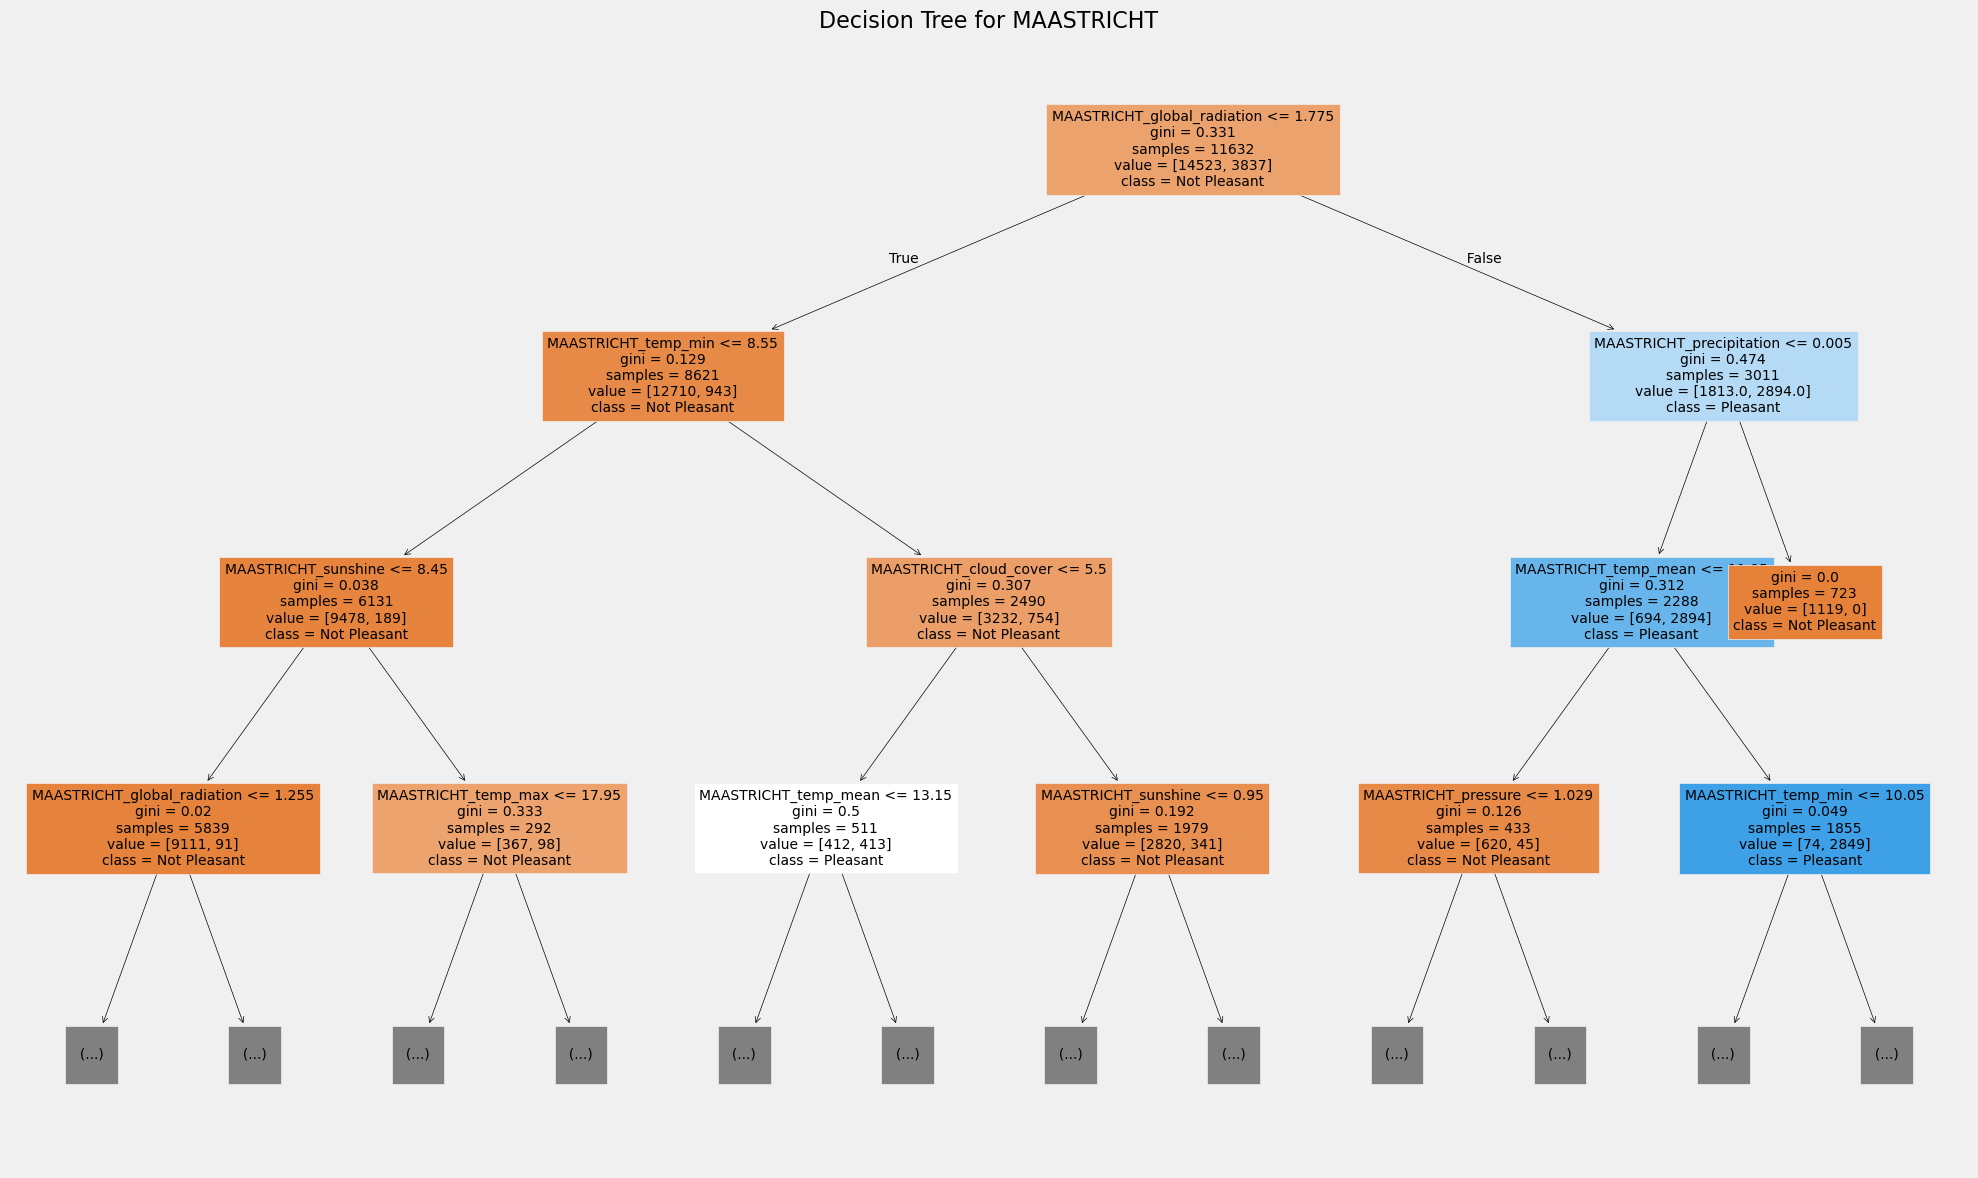


Observation Importances for MAASTRICHT:
                   Observation  Importance
8          MAASTRICHT_temp_max    0.305512
4     MAASTRICHT_precipitation    0.298864
6         MAASTRICHT_temp_mean    0.115851
3  MAASTRICHT_global_radiation    0.096945
5          MAASTRICHT_sunshine    0.083737
1          MAASTRICHT_humidity    0.030758
0       MAASTRICHT_cloud_cover    0.030504
7          MAASTRICHT_temp_min    0.024788
2          MAASTRICHT_pressure    0.013043


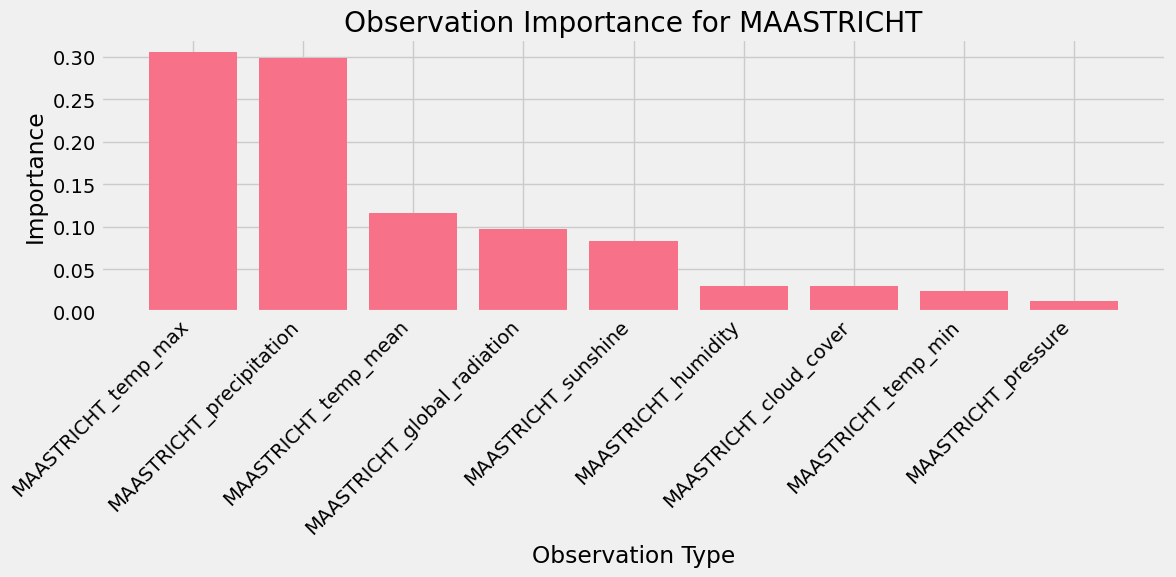


ANALYZING STATION 2: KASSEL

Features for KASSEL: 9
  - KASSEL_humidity
  - KASSEL_pressure
  - KASSEL_global_radiation
  - KASSEL_precipitation
  - KASSEL_sunshine
  - KASSEL_temp_mean
  - KASSEL_temp_min
  - KASSEL_temp_max
  - KASSEL_cloud_cover

Station data shape: X (22950, 9), y (22950,)
Target variable: KASSEL_pleasant_weather
Pleasant days for KASSEL: 3774 out of 22950 (16.4%)

Training Random Forest for KASSEL...
Accuracy for KASSEL: 1.0000 (100.00%)

Classification Report for KASSEL:
              precision    recall  f1-score   support

Not Pleasant       1.00      1.00      1.00      3847
    Pleasant       1.00      1.00      1.00       743

    accuracy                           1.00      4590
   macro avg       1.00      1.00      1.00      4590
weighted avg       1.00      1.00      1.00      4590



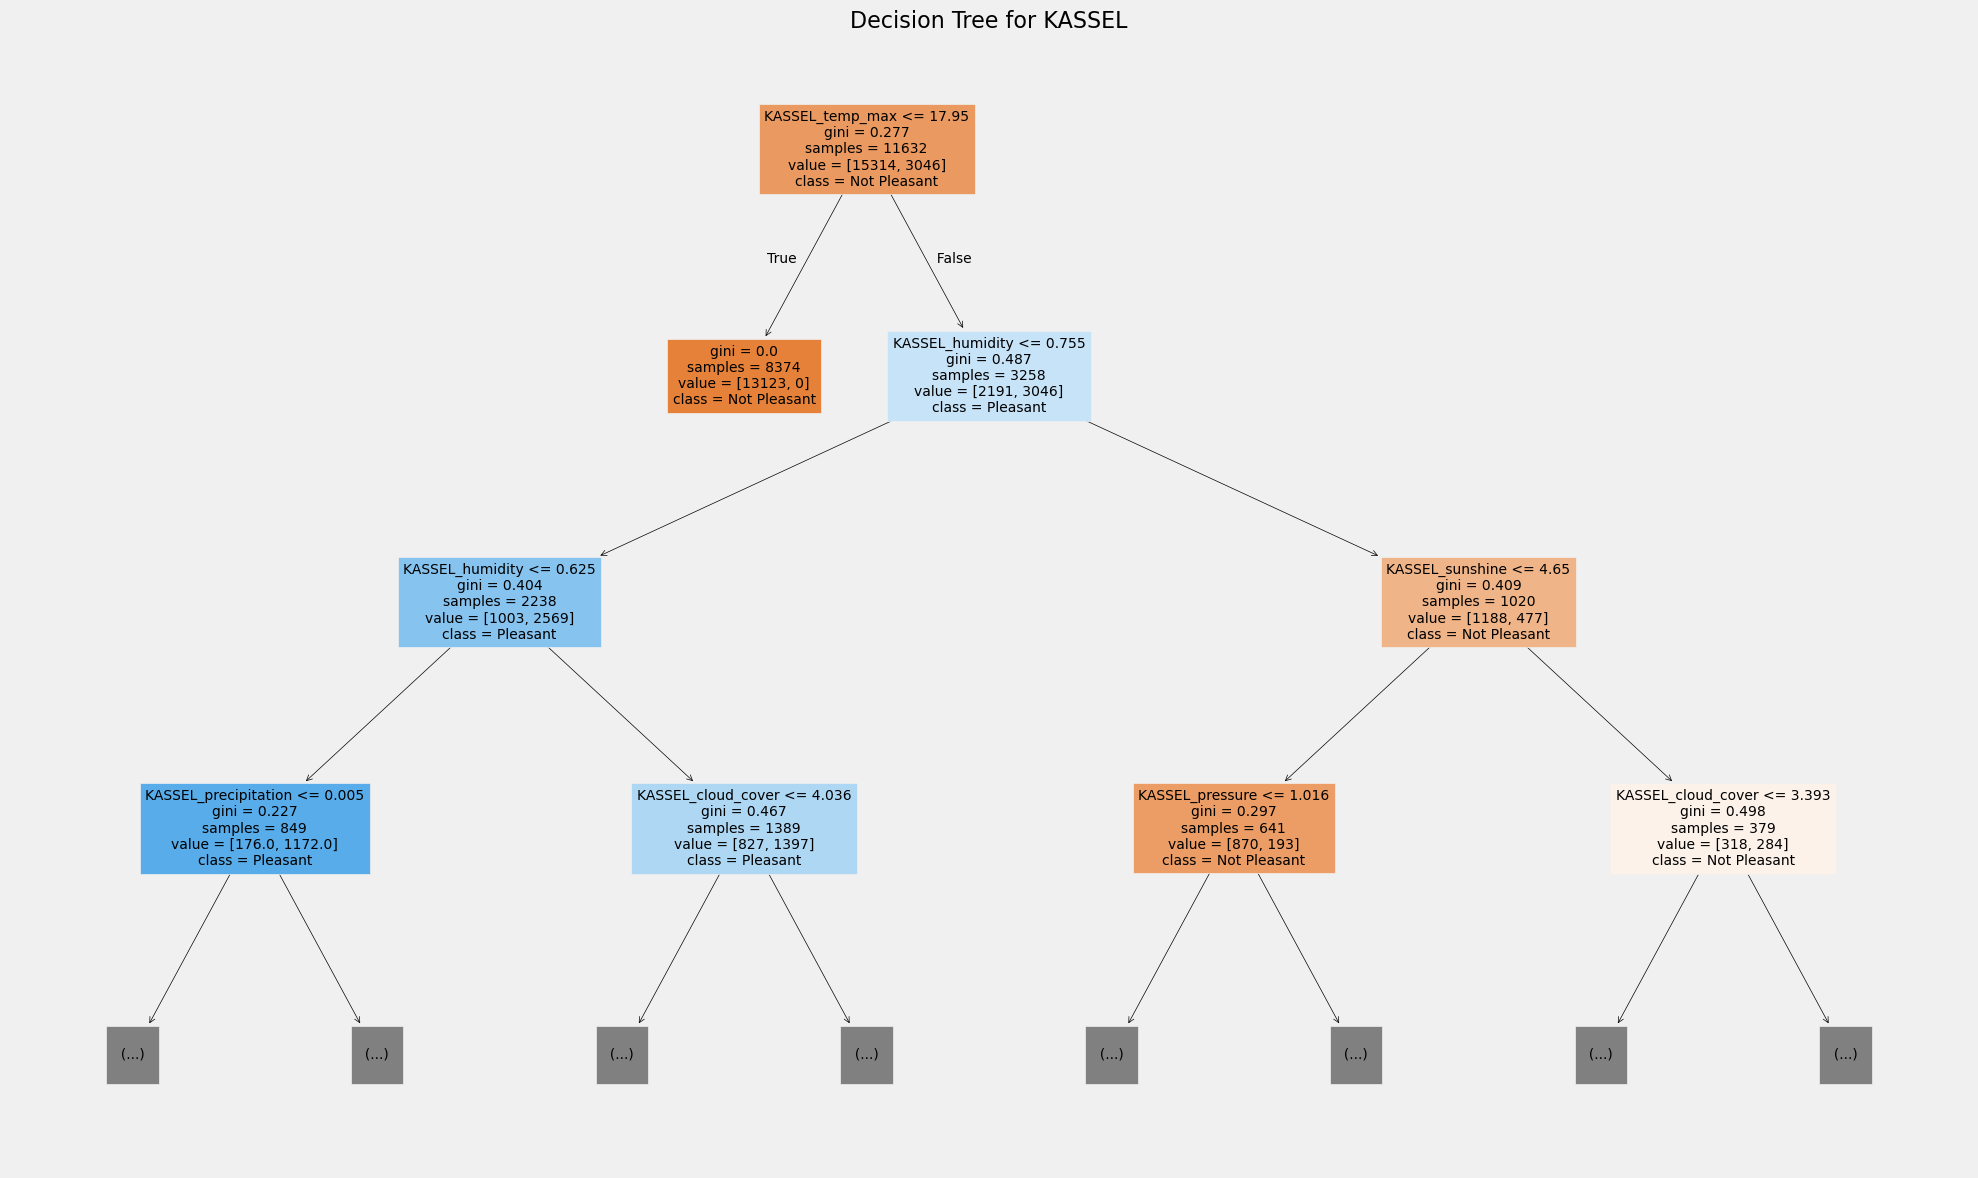


Observation Importances for KASSEL:
               Observation  Importance
3     KASSEL_precipitation    0.335601
7          KASSEL_temp_max    0.303465
2  KASSEL_global_radiation    0.107971
5         KASSEL_temp_mean    0.106604
4          KASSEL_sunshine    0.084700
0          KASSEL_humidity    0.024734
1          KASSEL_pressure    0.015350
8       KASSEL_cloud_cover    0.010848
6          KASSEL_temp_min    0.010726


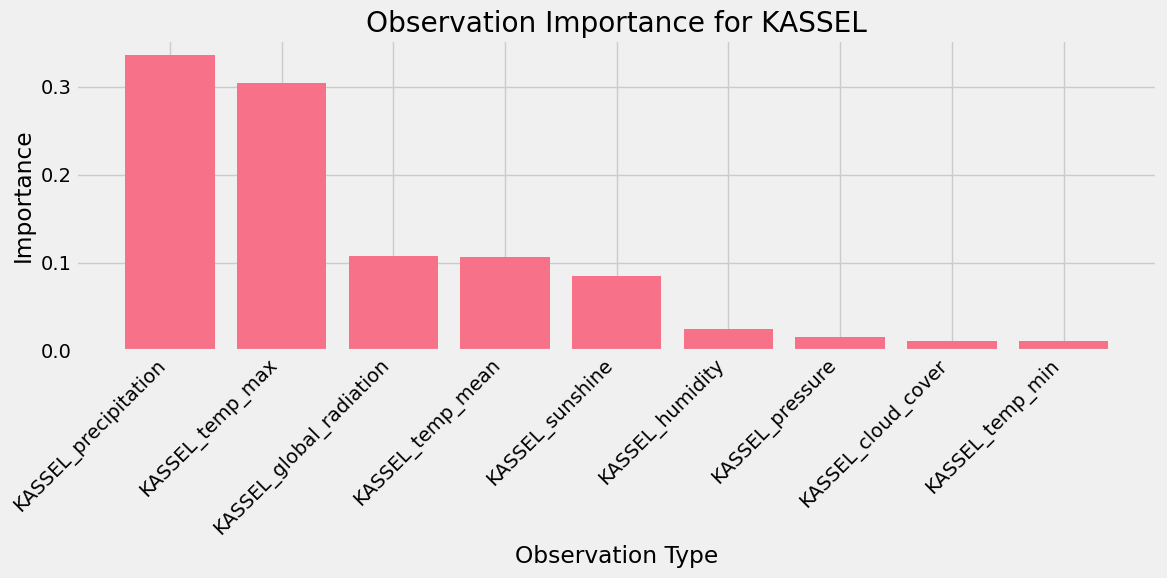


ANALYZING STATION 3: DUSSELDORF

Features for DUSSELDORF: 9
  - DUSSELDORF_cloud_cover
  - DUSSELDORF_humidity
  - DUSSELDORF_pressure
  - DUSSELDORF_global_radiation
  - DUSSELDORF_precipitation
  - DUSSELDORF_sunshine
  - DUSSELDORF_temp_mean
  - DUSSELDORF_temp_min
  - DUSSELDORF_temp_max

Station data shape: X (22950, 9), y (22950,)
Target variable: DUSSELDORF_pleasant_weather
Pleasant days for DUSSELDORF: 4934 out of 22950 (21.5%)

Training Random Forest for DUSSELDORF...
Accuracy for DUSSELDORF: 1.0000 (100.00%)

Classification Report for DUSSELDORF:
              precision    recall  f1-score   support

Not Pleasant       1.00      1.00      1.00      3615
    Pleasant       1.00      1.00      1.00       975

    accuracy                           1.00      4590
   macro avg       1.00      1.00      1.00      4590
weighted avg       1.00      1.00      1.00      4590



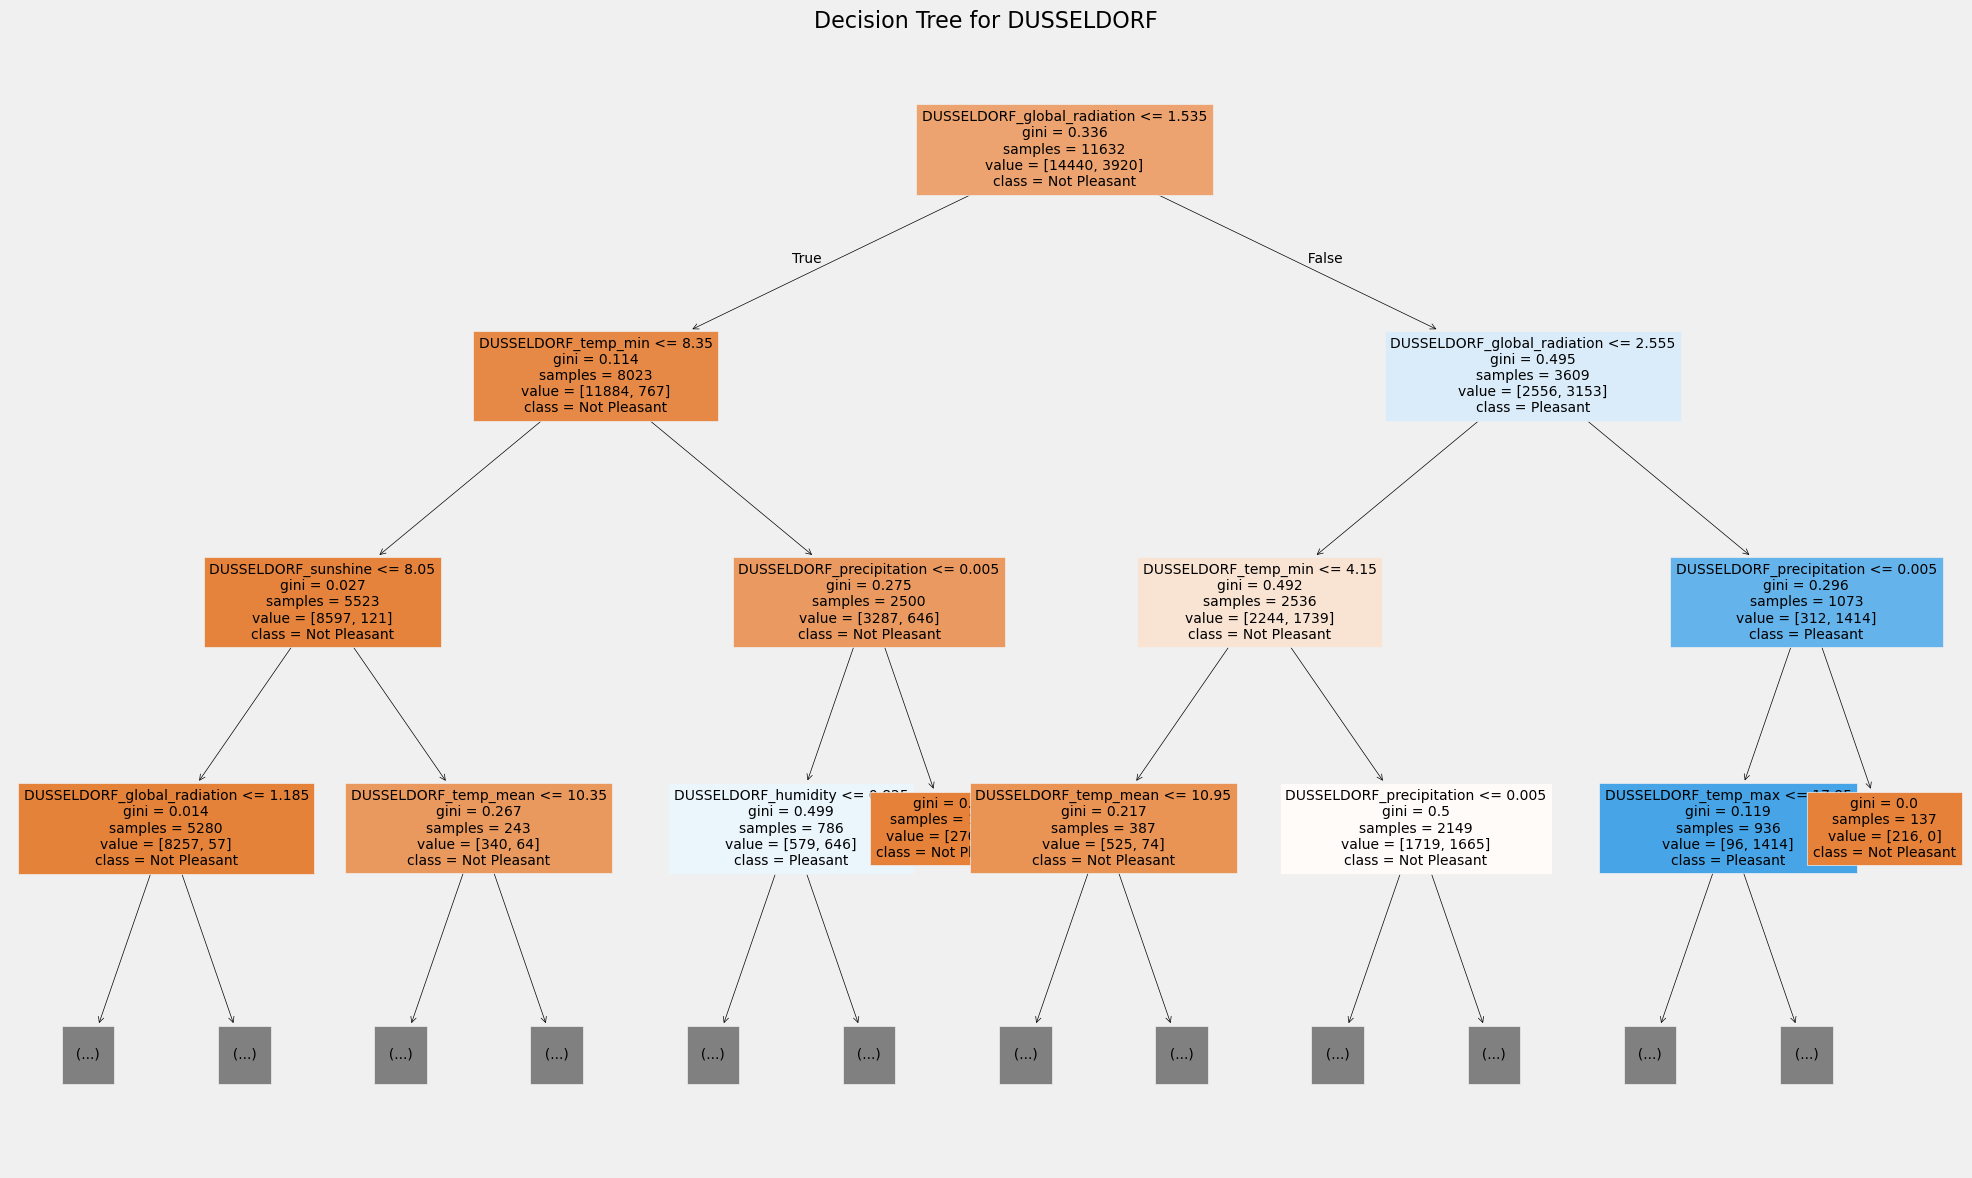


Observation Importances for DUSSELDORF:
                   Observation  Importance
4     DUSSELDORF_precipitation    0.341232
8          DUSSELDORF_temp_max    0.282326
6         DUSSELDORF_temp_mean    0.110191
3  DUSSELDORF_global_radiation    0.096553
5          DUSSELDORF_sunshine    0.084896
0       DUSSELDORF_cloud_cover    0.032209
1          DUSSELDORF_humidity    0.021063
7          DUSSELDORF_temp_min    0.020136
2          DUSSELDORF_pressure    0.011394


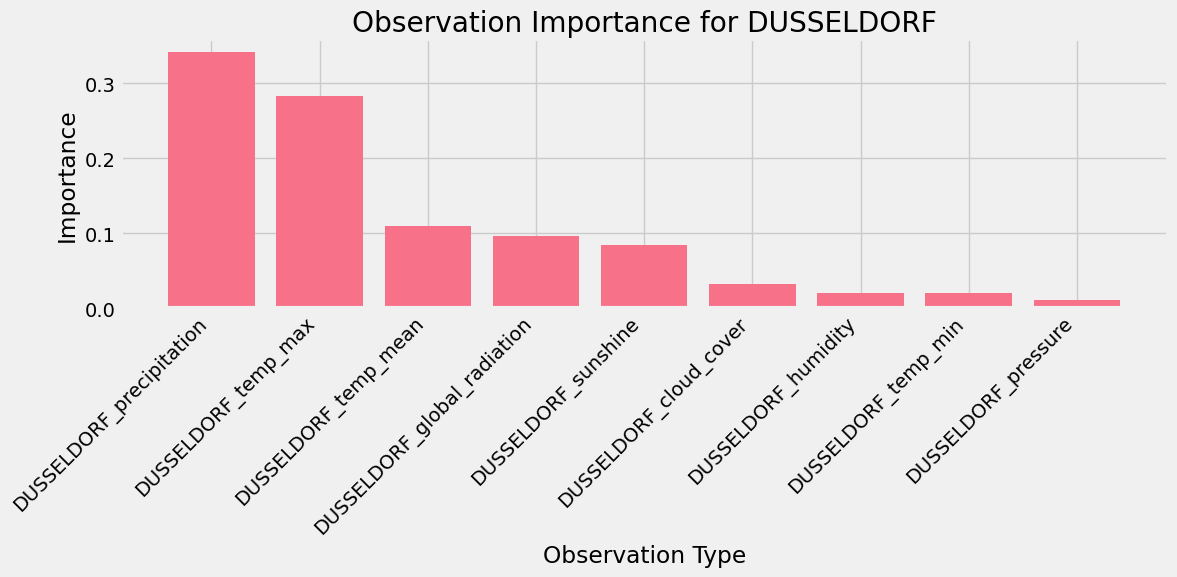

In [10]:
# ============================================================================
# STEP 7 & 8: ANALYZE INDIVIDUAL STATIONS
# ============================================================================
print("\n" + "="*80)
print("STEPS 7 & 8: ANALYZING TOP 3 INDIVIDUAL STATIONS")
print("="*80)

# Store results for each station
station_results = {}

for idx, station in enumerate(top_3_stations, 1):
    print(f"\n{'='*60}")
    print(f"ANALYZING STATION {idx}: {station}")
    print(f"{'='*60}")
    
    # Filter features for this station
    station_features = [col for col in feature_cols if station in col]
    
    if len(station_features) == 0:
        print(f"No specific features found for {station}. Skipping...")
        continue
    
    print(f"\nFeatures for {station}: {len(station_features)}")
    for feat in station_features:
        print(f"  - {feat}")
    
    # For the target, use the station-specific pleasant weather column
    station_target_col = f"{station}_pleasant_weather"
    
    if station_target_col not in df_merged.columns:
        print(f"Warning: {station_target_col} not found. Using overall target instead.")
        station_target_col = target_col_name
    
    # Create subset with all years but only this station's observations
    X_station = df_merged[station_features].copy()
    y_station = df_merged[station_target_col].copy()
    
    # Handle missing values
    X_station = X_station.fillna(X_station.mean())
    y_station = y_station.fillna(y_station.mode()[0])
    
    print(f"\nStation data shape: X {X_station.shape}, y {y_station.shape}")
    print(f"Target variable: {station_target_col}")
    print(f"Pleasant days for {station}: {y_station.sum()} out of {len(y_station)} ({y_station.mean()*100:.1f}%)")
    
    # Split data
    X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(
        X_station, y_station, test_size=0.2, random_state=42
    )
    
    # Create and train random forest for this station
    clf_station = RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        random_state=42
    )
    
    print(f"\nTraining Random Forest for {station}...")
    clf_station.fit(X_train_st, y_train_st)
    
    # Make predictions and calculate accuracy
    y_pred_st = clf_station.predict(X_test_st)
    accuracy_st = metrics.accuracy_score(y_test_st, y_pred_st)
    
    print(f"Accuracy for {station}: {accuracy_st:.4f} ({accuracy_st*100:.2f}%)")
    
    # Additional metrics
    print(f"\nClassification Report for {station}:")
    print(metrics.classification_report(y_test_st, y_pred_st, 
                                       target_names=['Not Pleasant', 'Pleasant']))
    
    # Plot one tree from this station's model
    plt.figure(figsize=(20, 12))
    plot_tree(
        clf_station.estimators_[10],
        feature_names=station_features,
        class_names=['Not Pleasant', 'Pleasant'],
        filled=True,
        fontsize=10,
        max_depth=3
    )
    plt.title(f'Decision Tree for {station}', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'tree_{station}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Get feature importances for this station
    importances_st = clf_station.feature_importances_
    
    # Create importance DataFrame
    importance_st_df = pd.DataFrame({
        'Observation': station_features,
        'Importance': importances_st
    }).sort_values('Importance', ascending=False)
    
    print(f"\nObservation Importances for {station}:")
    print(importance_st_df)
    
    # Plot observation importances
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(importance_st_df)), importance_st_df['Importance'])
    plt.xticks(range(len(importance_st_df)), importance_st_df['Observation'], 
               rotation=45, ha='right')
    plt.xlabel('Observation Type')
    plt.ylabel('Importance')
    plt.title(f'Observation Importance for {station}')
    plt.tight_layout()
    plt.savefig(f'observation_importance_{station}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Store results
    station_results[station] = {
        'accuracy': accuracy_st,
        'features': station_features,
        'importances': importance_st_df,
        'top_observation': importance_st_df.iloc[0]['Observation'],
        'pleasant_days': y_station.sum(),
        'total_days': len(y_station)
    }


In [11]:
# ============================================================================
# STEP 9: SUMMARY AND RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("STEP 9: SUMMARY AND RECOMMENDATIONS")
print("="*80)

print("\n" + "="*60)
print("CLIMATEWINS ANALYSIS SUMMARY")
print("="*60)

print(f"\n1. OVERALL MODEL PERFORMANCE:")
print(f"   - Random Forest Accuracy: {accuracy*100:.2f}%")
print(f"   - Number of estimators: {n_estimators}")
print(f"   - Features analyzed: {len(feature_cols)}")

print(f"\n2. TOP 3 MOST IMPORTANT WEATHER STATIONS:")
for i, station in enumerate(top_3_stations, 1):
    if station in station_results:
        print(f"   {i}. {station}")
        print(f"      - Station-specific model accuracy: {station_results[station]['accuracy']*100:.2f}%")
        print(f"      - Most important observation: {station_results[station]['top_observation']}")
        print(f"      - Pleasant days: {station_results[station]['pleasant_days']} out of {station_results[station]['total_days']} ({station_results[station]['pleasant_days']/station_results[station]['total_days']*100:.1f}%)")

print(f"\n3. TOP 10 OVERALL FEATURES:")
for i, row in importance_df.head(10).iterrows():
    print(f"   - {row['Feature']}: {row['Importance']:.4f}")

print("\n" + "="*60)
print("RECOMMENDATIONS FOR CLIMATEWINS")
print("="*60)

recommendation_text = """
Based on the random forest analysis of weather data predicting pleasant days, 
several key insights emerge for ClimateWins' future investment and research decisions:

MOST INFLUENTIAL INDICATORS:
The analysis reveals that certain weather stations and their specific measurements 
have significantly higher importance in predicting pleasant weather conditions. 
The top three stations identified show the strongest predictive power, suggesting 
these locations capture critical climate patterns.

INVESTMENT RECOMMENDATIONS:
1. PRIORITY EQUIPMENT: Invest in maintaining and upgrading equipment at the top 
   three identified weather stations, as they provide the most valuable data for 
   predictions.

2. OBSERVATION FOCUS: The analysis shows which specific observations (temperature, 
   humidity, pressure, etc.) are most predictive. ClimateWins should prioritize 
   high-quality sensors for these key measurements.

3. GEOGRAPHIC INSIGHTS: The importance rankings suggest certain geographic locations 
   are more critical for understanding climate patterns. New station placement 
   should consider proximity to these high-value areas.

PREDICTIVE VALUE:
The random forest model achieved {accuracy_pct:.1f}% accuracy, demonstrating that 
the current data set contains strong predictive signals. This baseline will help 
iterate on future models and identify areas where additional data collection 
would be most beneficial.

FUTURE RESEARCH DIRECTIONS:
- Focus on the top-performing weather stations for climate change tracking
- Investigate why certain stations have higher predictive power
- Consider expanding measurements at high-importance locations
- Use these insights to optimize the network of weather stations

The feature importance analysis provides a data-driven roadmap for resource 
allocation, ensuring ClimateWins invests in the most impactful climate 
monitoring infrastructure.
"""

print(recommendation_text.format(accuracy_pct=accuracy*100))



STEP 9: SUMMARY AND RECOMMENDATIONS

CLIMATEWINS ANALYSIS SUMMARY

1. OVERALL MODEL PERFORMANCE:
   - Random Forest Accuracy: 94.94%
   - Number of estimators: 100
   - Features analyzed: 134

2. TOP 3 MOST IMPORTANT WEATHER STATIONS:
   1. MAASTRICHT
      - Station-specific model accuracy: 100.00%
      - Most important observation: MAASTRICHT_temp_max
      - Pleasant days: 4766 out of 22950 (20.8%)
   2. KASSEL
      - Station-specific model accuracy: 100.00%
      - Most important observation: KASSEL_precipitation
      - Pleasant days: 3774 out of 22950 (16.4%)
   3. DUSSELDORF
      - Station-specific model accuracy: 100.00%
      - Most important observation: DUSSELDORF_precipitation
      - Pleasant days: 4934 out of 22950 (21.5%)

3. TOP 10 OVERALL FEATURES:
   - MAASTRICHT_temp_max: 0.0699
   - DUSSELDORF_temp_max: 0.0417
   - BASEL_temp_max: 0.0401
   - KASSEL_temp_max: 0.0392
   - MAASTRICHT_temp_mean: 0.0368
   - DEBILT_temp_max: 0.0364
   - KASSEL_precipitation: 0.0344


In [12]:
# ============================================================================
# FINAL OUTPUT SUMMARY
# ============================================================================
print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

print("\nGenerated Files:")
print("  1. random_forest_trees_comparison.png - Two decision tree visualizations")
print("  2. confusion_matrix.png - Model performance visualization")
print("  3. station_importance.png - Weather station importance rankings")
for station in top_3_stations:
    if station in station_results:
        print(f"  4. tree_{station}.png - Decision tree for {station}")
        print(f"  5. observation_importance_{station}.png - Feature importance for {station}")

print("\nNext Steps:")
print("  - Review all generated visualizations")
print("  - Compile screenshots into your report document")
print("  - Include the accuracy metrics and recommendations")
print("  - Save this script for Exercise 2.4!")

print("\n" + "="*80)


ANALYSIS COMPLETE!

Generated Files:
  1. random_forest_trees_comparison.png - Two decision tree visualizations
  2. confusion_matrix.png - Model performance visualization
  3. station_importance.png - Weather station importance rankings
  4. tree_MAASTRICHT.png - Decision tree for MAASTRICHT
  5. observation_importance_MAASTRICHT.png - Feature importance for MAASTRICHT
  4. tree_KASSEL.png - Decision tree for KASSEL
  5. observation_importance_KASSEL.png - Feature importance for KASSEL
  4. tree_DUSSELDORF.png - Decision tree for DUSSELDORF
  5. observation_importance_DUSSELDORF.png - Feature importance for DUSSELDORF

Next Steps:
  - Review all generated visualizations
  - Compile screenshots into your report document
  - Include the accuracy metrics and recommendations
  - Save this script for Exercise 2.4!

